# **CA4 @ AI Spring 2025**
# Convolutional vs. Fully Connected Neural Networks

- **Name:** MohammadSepehrBazargan
- **Student ID:** 810102303

---
Your submission should be named using the following format: `AI_CA4_LASTNAME_STUDENTID.ipynb`.

---

 *How to do this problem set:*

- Some questions require writing Python code and computing results, and the rest of them have written answers. For coding problems, you will have to fill out all code blocks that say `YOUR CODE HERE`.

- For text-based answers, you should replace the text that says `WRITE YOUR ANSWER HERE` with your actual answer.
---
If you have any further questions or concerns, contact the TAs via email or Telegram.

# Introduction
In this assignment, you will compare fully connected neural networks with convolutional neural networks to evaluate whether convolutional architectures offer superior performance—and understand the reasons behind any observed differences.

**Important Note:**

Before you begin, please make sure to review the accompanying PyTorch tutorial provided alongside this file.

## Colab Setup

If you are running this notebook on Google Colab, you can mount your Google Drive using the following code to access or upload files directly from your Drive.

In [1]:
# from google.colab import drive
# import os

# drive.mount('/content/drive')

# GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', 'AIS25-CA4')
# os.chdir(GOOGLE_DRIVE_PATH)

## Device

As demonstrated in the PyTorch tutorial, PyTorch enable you to run your code on GPU to accelerate computations.

In [2]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Dataset

## Transforms & Dataset & Dataloader

Here, you should download and load the dataset with the desire transforms. After that, you should split train dataset to train and validation sets. Finally, define the dataloaders for `train`, `validation` and `test`

In [3]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [4]:
from torchvision import transforms

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)),
])

In [5]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torchvision

batch_size = 512

initial_trainset = torchvision.datasets.CIFAR10(root='/kaggle/input/cifar-10', train=True, download=False, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='/kaggle/input/cifar-10', train=False, download=False, transform=transform_test)

trainset, valset = random_split(initial_trainset, [45000, 5000])

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False) 
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

## DataLoader vs Dataset

The advantage of using dataloaders is we can process the data in batches and shuffle them as we want so shuffling helps us prevent the model to learn from specific patterns and processing data in batches comes in handy when we use GPU so we can process the data in parallel rather than going through it one by one in the dataset format.

dataset is useful when we want information on specific parts of data or a single individual data, in that way using dataset to accessing the information is easier than DataLoader

## Visualization

Visualize 5 random images from each class in different columns

- **Hint**:  You can use `plt.subplots` for visualization

In [6]:
# inverse the normilize transform to restore the original data
import torch

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def __call__(self, tensor, gray=False, coeff=(0.3, 0.59, 0.11)):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be unnormalized.
        Returns:
            Tensor: Unnormalized image.
        """
        self.mean = self.mean.view(-1, 1, 1)
        self.std = self.std.view(-1, 1, 1)
        return tensor.clone() * self.std.to(tensor.device) + self.mean.to(tensor.device)

norminv = UnNormalize(mean=(0.491, 0.482, 0.446), std=(0.247, 0.243, 0.261))

## UnNormalization :

so transforms.Normalize normalizes a tensor image by subtracting the mean and dividing by the standard deviation for each channel, here we just do the opposite we add the std and multiply by mean.

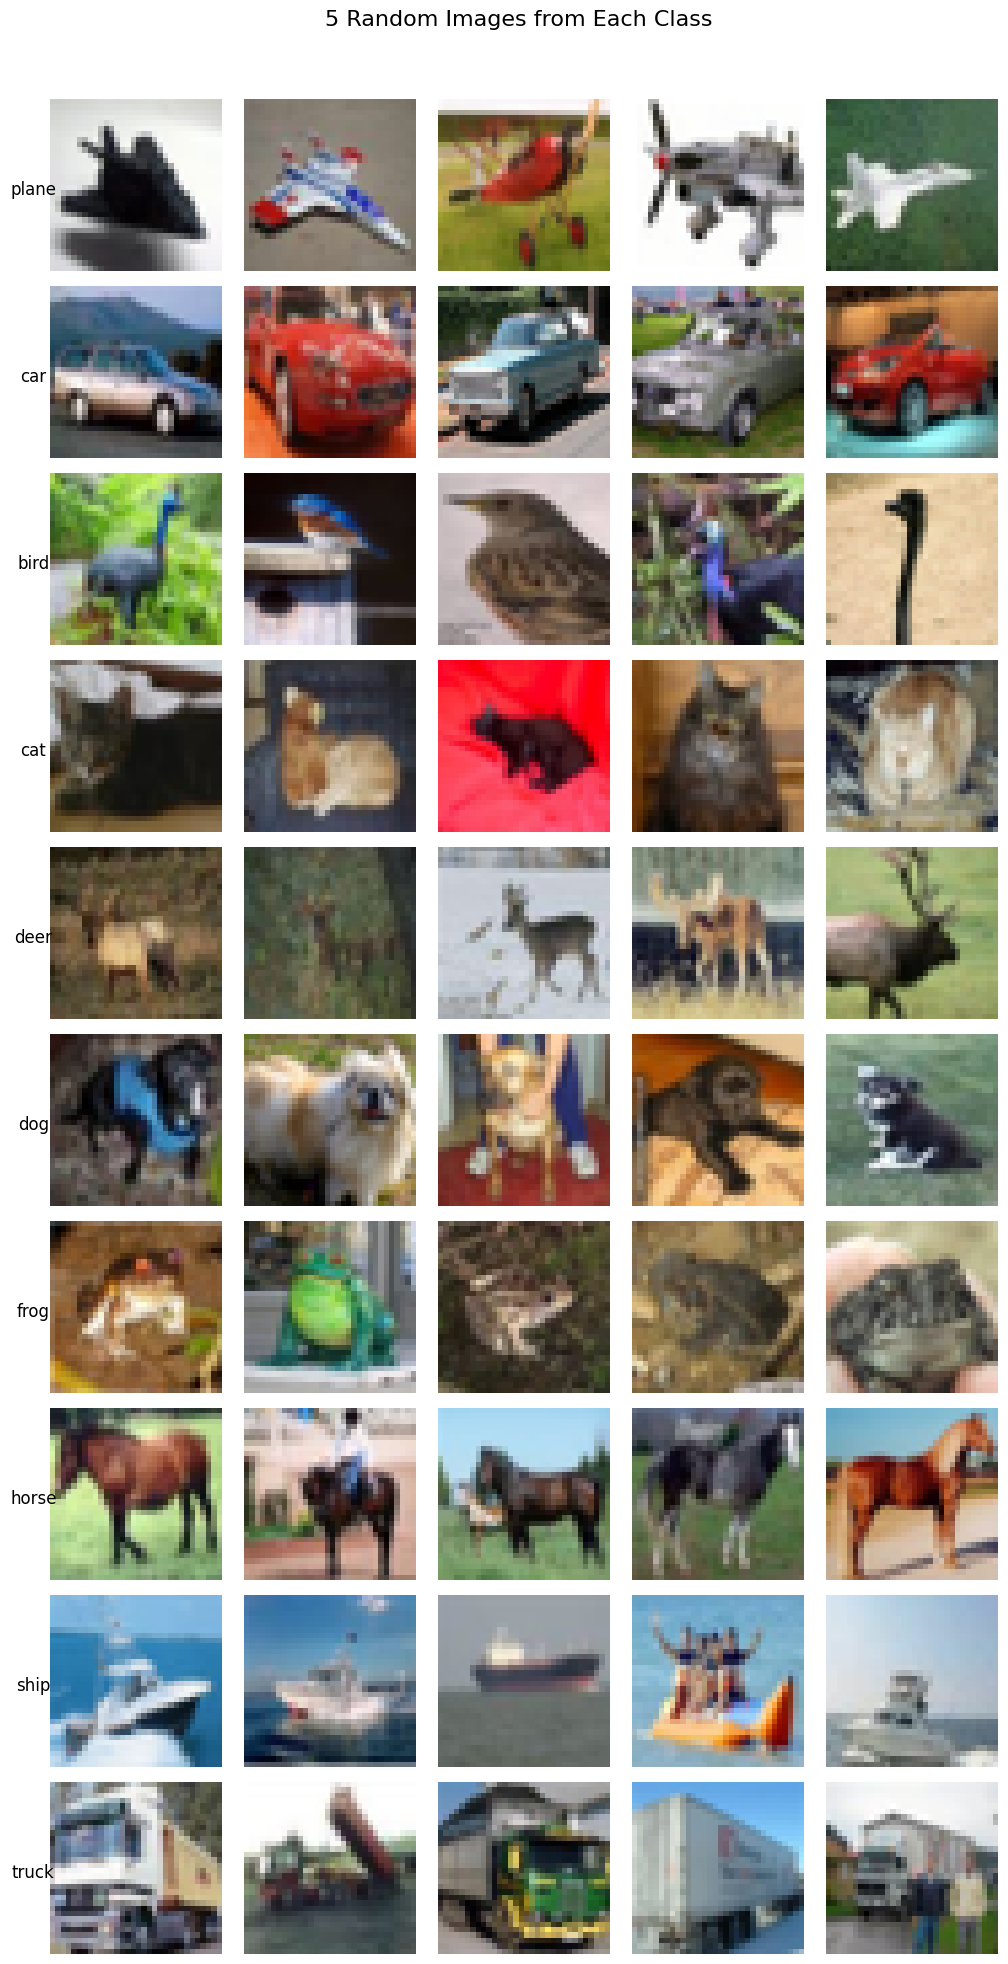

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import random

images_per_class = {i: [] for i in range(10)}
images_to_collect = 5

indices = list(range(len(initial_trainset)))
#random.shuffle(indices)

for idx in indices:
    #breaks if we have seen five of all the classes
    if all(len(images_per_class[c]) == images_to_collect for c in range(10)):
        break
    
    image, label = initial_trainset[idx]
    
    #gets which class we still need image for
    if len(images_per_class[label]) < images_to_collect:
        images_per_class[label].append(image)

# --- Plotting --- #
fig, axs = plt.subplots(10, images_to_collect, figsize=(10, 20))
fig.suptitle('5 Random Images from Each Class', fontsize=16)

for class_idx, image_list in images_per_class.items():
    for i, image_tensor in enumerate(image_list):
        unnormalized_img = norminv(image_tensor)
        
        # Convert tensor to numpy array and rearrange dimensions for plotting
        # PyTorch tensors are (C, H, W), Matplotlib expects (H, W, C)
        img_to_plot = unnormalized_img.permute(1, 2, 0).numpy()
        
        ax = axs[class_idx, i]
        ax.imshow(img_to_plot)
        ax.axis('off')
        
        if i == 0:
            ax.set_title(classes[class_idx], rotation=0, x=-0.1, y=0.4)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Fully Connected Neural Netwrok

Your first task is to build a fully connected neural network with PyTorch. To achieve this, it is recommended that you familiarize yourself with the following PyTorch components and incorporate them into your network architecture:

* [`nn.Module`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Module.html)
* [`nn.Sequential`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Sequential.html)
* [`nn.Linear`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html)
* [`nn.ReLU`](https://docs.pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
* [`nn.Dropout`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Dropout.html)
* [`nn.Flatten`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Flatten.html)

In the provided template below, the final layer of the model should be defined separately and assigned the name `linear`, as it will be referenced in a later section of this assignment.

To ensure a fair comparison with convolutional neural networks (CNNs), both models should have approximately the same number of trainable parameters. Specifically, the fully connected model should contain **33,500,000 ± 500,000** trainable parameters.

You will calculate the exact number of trainable parameters in the following subsection to ensure this requirement is met.




In [8]:
import torch
import numpy as np
import torchvision
import torch.nn as nn
import math
from torchvision import transforms

class FullyConnectedNetwork(nn.Module):
    def __init__(self, input_shape=(3, 32, 32), num_classes=10):
        super(FullyConnectedNetwork, self).__init__()
        input_features = input_shape[0] * input_shape[1] * input_shape[2] 

        self.network_core = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_features, 10500),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(10500, 120),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        self.linear = nn.Linear(120, num_classes)

    def forward(self, x):
        x = self.network_core(x)
        x = self.linear(x)
        return x

## init : 
we get the data and cacluate the input features by 3x32x32 which is CxHxW, then in the sequential we flatten it so we had tensors up until now but linear needs a one dimensional vector which we need to flatten the tensros for it, define the first linear layer to get 3072 inputs and ouput 10500 features then the second layer to get those 10500 features and output 120 features and lastly the final linear layer to get 120 inputs and output 10 scores which are our classes. 

ReLU is our activation function and *Dropout* is a lyaer which performs regularization so we don't oveerfit on the test data basically it randomly changes some of the activations into 0 during the training.

## Trainable params

Based on the defined architecture, manually calculate the total number of trainable parameters:

So for a linear model like nn.linear(input_features,output_features) we calculate the parameters in this way :

Each neron in the first layer is connected to all the neurons in the second layer which gives us our weights so we have : inout Then each neuron has a bias so we have "out" biases final parameters would be : inout + out

for the firsy layer we have : 3072x10500 + 10500 = 32,266,500 second layer would be : 10500x120 + 120 = 1,260,000 last layer : 120x10 + 10 = 1210 so the final parameters are : 33,527,830

Once you have completed your hand calculation, you can verify your result by running the following cell:

In [9]:
from torchsummary import summary
summary(FullyConnectedNetwork().to(device), input_size=(3, 32, 32));

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                [-1, 10500]      32,266,500
              ReLU-3                [-1, 10500]               0
           Dropout-4                [-1, 10500]               0
            Linear-5                  [-1, 120]       1,260,120
              ReLU-6                  [-1, 120]               0
           Dropout-7                  [-1, 120]               0
            Linear-8                   [-1, 10]           1,210
Total params: 33,527,830
Trainable params: 33,527,830
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.27
Params size (MB): 127.90
Estimated Total Size (MB): 128.18
----------------------------------------------------------------


## Train

### Model Instantiation

Create an instance of your model and move it to your selected device (CPU or GPU). Refer to the PyTorch-tutorial notebook for guidance on how to perform this operation.

In [10]:
model = FullyConnectedNetwork().to(device)

### Criterion & Optimizer


To train a neural network, we require a **loss function** (referred to as the *criterion*) to quantify the difference between the model's predictions and the true labels. This loss is then used to compute the gradients of the model parameters.

In addition, an **optimization algorithm** is needed to update the model's parameters using the calculated gradients, in order to minimize the loss over time.

You are encouraged to read about the following PyTorch components:

* [`nn.CrossEntropyLoss`](https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
* [`torch.optim.Adam`](https://docs.pytorch.org/docs/stable/generated/torch.optim.Adam.html)

In [11]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

## CrossEntropyLoss
This is a multiclass loss function it performs two steps : 

1. Apply the softmax : basically convert the outputs of the final layer into probabilities using a softmax function.
2. calculates the likelihood : same as the formula explained in class loss is calculated by gettin -log from the probability that is assigned to the single correct class

Its useful because it penalizes the model heavily when it selects a wrong class with high confidence. 

## Adam 
So the job of an optimizer is to define how are we moving towards the new minimum, we calculated the loss and know where will it be reduced but optimizer shows us how fast should we go in the directon of it.

diffrences between Adam and SGD are :

1. Adam uses adaptive learning rate, its not a hardcoded number so for each parameter Adam keeps a diffrent learning rate and adjusts it during training.
2. Adam has a concept called momentum which helps the model to move faster and more consistently in the correct direction.

### Train loop

Train your model

Tasks:
- Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- save train/validation loss and accuracy (of each epoch) in an array for later usage

In [12]:
def train_epoch(net: torch.nn.Module, criterion: torch.nn.Module, optimizer: torch.optim.Optimizer ,dataloader: torch.utils.data.DataLoader):
    """
    Trains the neural network for a single epoch.

    Args:
        net (torch.nn.Module): The neural network model to be trained.
        criterion (torch.nn.Module): The loss function used to compute the training loss.
        optimizer (torch.optim.Optimizer): The optimization algorithm used to update model parameters.
        dataloader (torch.utils.data.DataLoader): DataLoader providing the training data in batches.

    Returns:
        tuple:
            - avg_loss (float): The average loss across all batches in the epoch.
            - accuracy (float): The classification accuracy (in percentage) over the entire dataset for the epoch.

    Notes:
        - The `criterion` computes the loss between the model's predictions and the true labels.
        - The `optimizer` updates the model's parameters based on the computed gradients to minimize the loss.
    """
    net.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    
    for inputs, labels in dataloader:
        
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        # computing gradient of the loss
        loss.backward()
        # perform optimizaton
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
    
    avg_loss , accuracy = running_loss / total_samples, 100 * correct_predictions / total_samples
    return avg_loss, accuracy

def eval_epoch(net: torch.nn.Module, criterion: torch.nn.Module, dataloader: torch.utils.data.DataLoader, test_mode: bool = False):
    """
    Evaluates the neural network on a validation or test dataset for one epoch.
    """
    net.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    
    avg_loss , accuracy = running_loss / total_samples, 100 * correct_predictions / total_samples
    return avg_loss, accuracy

As previously mentioned, ensuring a fair comparison between models requires consistency in certain aspects of the training setup. One key factor is the number of **trainable parameters**, and another is the number of times the model processes the entire dataset—referred to as an **epoch**.

To maintain consistency in training duration across models, **do not modify** the `epochs` variable defined below.


In [13]:
epochs = 60 # Do not modify

history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}


for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, criterion, optimizer, trainloader)
    val_loss, val_acc = eval_epoch(model, criterion, valloader)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"(Epoch {epoch + 1} / {epochs}) train loss:{train_loss: .4f}; train acc:{train_acc: .2f}%; val loss:{val_loss: .4f}; val_acc:{val_acc: .2f}%")

(Epoch 1 / 60) train loss: 1.8625; train acc: 34.11%; val loss: 1.6702; val_acc: 41.82%
(Epoch 2 / 60) train loss: 1.6810; train acc: 41.22%; val loss: 1.5845; val_acc: 44.60%
(Epoch 3 / 60) train loss: 1.6035; train acc: 44.10%; val loss: 1.5290; val_acc: 46.86%
(Epoch 4 / 60) train loss: 1.5417; train acc: 46.14%; val loss: 1.4863; val_acc: 48.34%
(Epoch 5 / 60) train loss: 1.4867; train acc: 48.30%; val loss: 1.4557; val_acc: 48.80%
(Epoch 6 / 60) train loss: 1.4473; train acc: 49.68%; val loss: 1.4389; val_acc: 49.94%
(Epoch 7 / 60) train loss: 1.4059; train acc: 51.03%; val loss: 1.4319; val_acc: 49.58%
(Epoch 8 / 60) train loss: 1.3745; train acc: 52.15%; val loss: 1.3955; val_acc: 51.58%
(Epoch 9 / 60) train loss: 1.3349; train acc: 53.46%; val loss: 1.3807; val_acc: 51.34%
(Epoch 10 / 60) train loss: 1.3142; train acc: 54.06%; val loss: 1.3743; val_acc: 51.20%
(Epoch 11 / 60) train loss: 1.2924; train acc: 55.20%; val loss: 1.3638; val_acc: 52.46%
(Epoch 12 / 60) train loss: 1.

### Save Model

Save the trained model for use in subsequent sections to avoid retraining it later.


In [14]:
torch.save(model.state_dict(), "fully-connected.pth")

In [15]:
# To load the previously saved model, simply uncomment the code below.
#model.load_state_dict(torch.load('fully-connected.pth'))

### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

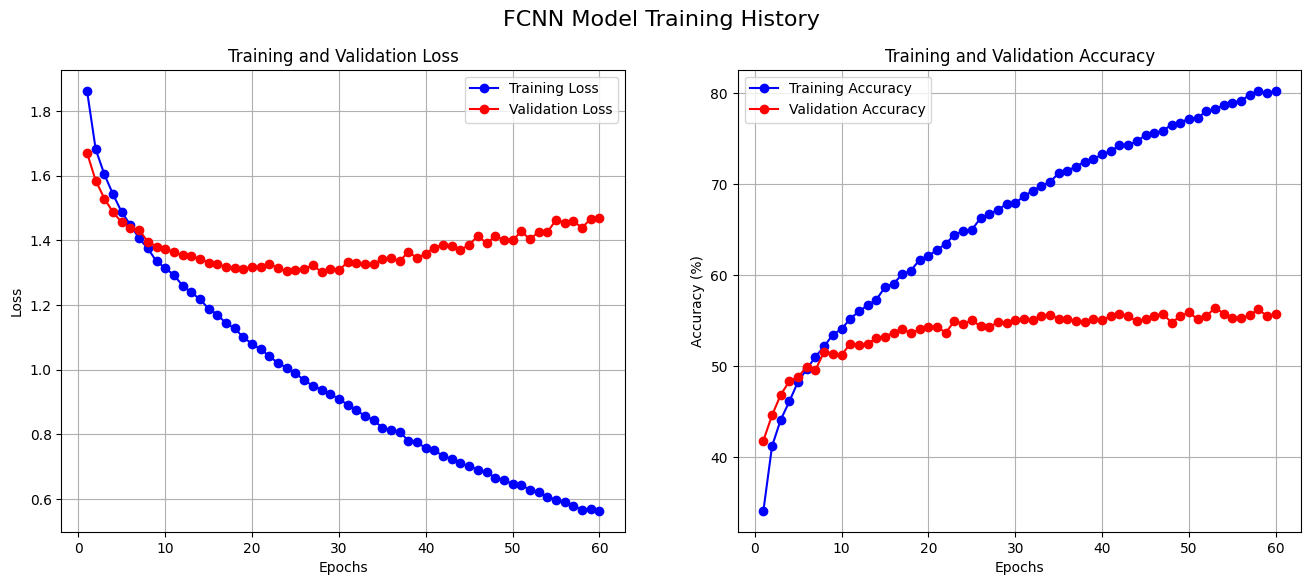

In [16]:
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- Plot Loss ---
ax1.plot(epochs_range, history['train_loss'], 'b-o', label='Training Loss')
ax1.plot(epochs_range, history['val_loss'], 'r-o', label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# --- Plot Accuracy ---
ax2.plot(epochs_range, history['train_acc'], 'b-o', label='Training Accuracy')
ax2.plot(epochs_range, history['val_acc'], 'r-o', label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

fig.suptitle('FCNN Model Training History', fontsize=16)
plt.show()

## Overfitting
yes, overfitting has happened by looking at the plots we see that the validation loss is stable at 1.4 but the train loss is continously decreased till less that 0.5 and its accruacy is 80% while we have 56% validation accuracy, train accuracy of 80% alone is not a problem but with validation being 56% and this large margin between the validation and train loss we can find out that overfitting on the train data has happened.

## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `60%`

In [17]:
print("Evaluating model on the test dataset...")

test_loss, test_accuracy = eval_epoch(model, criterion, testloader)

print("-" * 30)
print(f"Final Test Loss: {test_loss:.4f}")
print(f"Final Test Accuracy: {test_accuracy:.2f}%")
print("-" * 30)

Evaluating model on the test dataset...
------------------------------
Final Test Loss: 1.4176
Final Test Accuracy: 57.12%
------------------------------


# Convolutional Neural Network

## Model

Define your model here from scratch (You are not allowed to use the existing models in pytorch)

**NOTICE:** The model that you will have defined outputs a vector containing 10 numbers (for each class). Define a "feature space" that is a vector of size *N* (where *N > 10*) right before the last layer (You can then have a last layer like `nn.Linear(N, 10)`). See the image below to get a better understanding. We will use this later (we want to access the feature space of a sample when the sample is given to the model). The model tries to learn a representation of the samples in this feature space and we will see how good it could do this in later sections.

![Feature Space In Neural Network](https://i.postimg.cc/28Qjcn9D/feature-space-vis.png)

 You are encouraged to learn about the following core components commonly used in convolutional neural networks:

* [`nn.Conv2d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
* [`nn.MaxPool2d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)

**Reminder**: The model you define should contain 33,500,000 ± 500,000 trainable parameters.

In [18]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        
        self.conv_extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output: 64x16x16
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output: 128x8x8
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 256x4x4
        )

        self.feature_space_generator = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4096, 8100),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        self.linear = nn.Linear(8100, num_classes)

    def forward(self, x, return_features=False):
        features_conv = self.conv_extractor(x)
        features_space = self.feature_space_generator(features_conv)
        output = self.linear(features_space)

        if return_features:
            return output, features_space
        
        return output

## Trainable params

Based on the defined architecture, manually calculate the total number of trainable parameters:

`WRITE YOUR ANSWER HERE`

Once you have completed your hand calculation, you can verify your result by running the following cell:

In [19]:
from torchsummary import summary
summary(CNN().to(device), input_size=(3, 32, 32));

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]          73,856
              ReLU-5          [-1, 128, 16, 16]               0
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 256, 8, 8]         295,168
              ReLU-8            [-1, 256, 8, 8]               0
         MaxPool2d-9            [-1, 256, 4, 4]               0
          Flatten-10                 [-1, 4096]               0
           Linear-11                 [-1, 8100]      33,185,700
             ReLU-12                 [-1, 8100]               0
          Dropout-13                 [-1, 8100]               0
           Linear-14                   

## Train

### Model instantiation

Create an instance of your model and move it to `device`

In [20]:
model = CNN().to(device)

### Criterion & Optimizer

Define `criterion` and `optimizer`

In [21]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Train loop

Train your model

Tasks:
- Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- save train/validation loss and accuracy (of each epoch) in an array for later usage

In [22]:
epochs = 60 # Do not modify
history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, criterion, optimizer, trainloader)
    val_loss, val_acc = eval_epoch(model, criterion, valloader)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"(Epoch {epoch + 1} / {epochs}) train loss:{train_loss: .4f}; train acc:{train_acc: .2f}%; val loss:{val_loss: .4f}; val_acc:{val_acc: .2f}%")

(Epoch 1 / 60) train loss: 1.6427; train acc: 40.18%; val loss: 1.3096; val_acc: 52.12%
(Epoch 2 / 60) train loss: 1.1628; train acc: 58.22%; val loss: 1.0505; val_acc: 62.04%
(Epoch 3 / 60) train loss: 0.9387; train acc: 66.59%; val loss: 0.8938; val_acc: 66.92%
(Epoch 4 / 60) train loss: 0.7996; train acc: 71.82%; val loss: 0.8333; val_acc: 69.50%
(Epoch 5 / 60) train loss: 0.6905; train acc: 75.84%; val loss: 0.7598; val_acc: 72.86%
(Epoch 6 / 60) train loss: 0.5944; train acc: 79.35%; val loss: 0.7340; val_acc: 74.20%
(Epoch 7 / 60) train loss: 0.5027; train acc: 82.41%; val loss: 0.7450; val_acc: 73.74%
(Epoch 8 / 60) train loss: 0.4311; train acc: 84.98%; val loss: 0.7465; val_acc: 74.24%
(Epoch 9 / 60) train loss: 0.3518; train acc: 87.80%; val loss: 0.7322; val_acc: 75.38%
(Epoch 10 / 60) train loss: 0.2699; train acc: 90.64%; val loss: 0.7716; val_acc: 75.90%
(Epoch 11 / 60) train loss: 0.2143; train acc: 92.44%; val loss: 0.8017; val_acc: 75.62%
(Epoch 12 / 60) train loss: 0.

### Save Model

Since changes need to be made to the model later on, it is advisable to save your model to avoid having to retrain it in case of any issues.

In [23]:
torch.save(model.state_dict(), "cnn.pth")

In [24]:
# To load the previously saved model, simply uncomment the code below.
model.load_state_dict(torch.load('cnn.pth'))

<All keys matched successfully>

### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

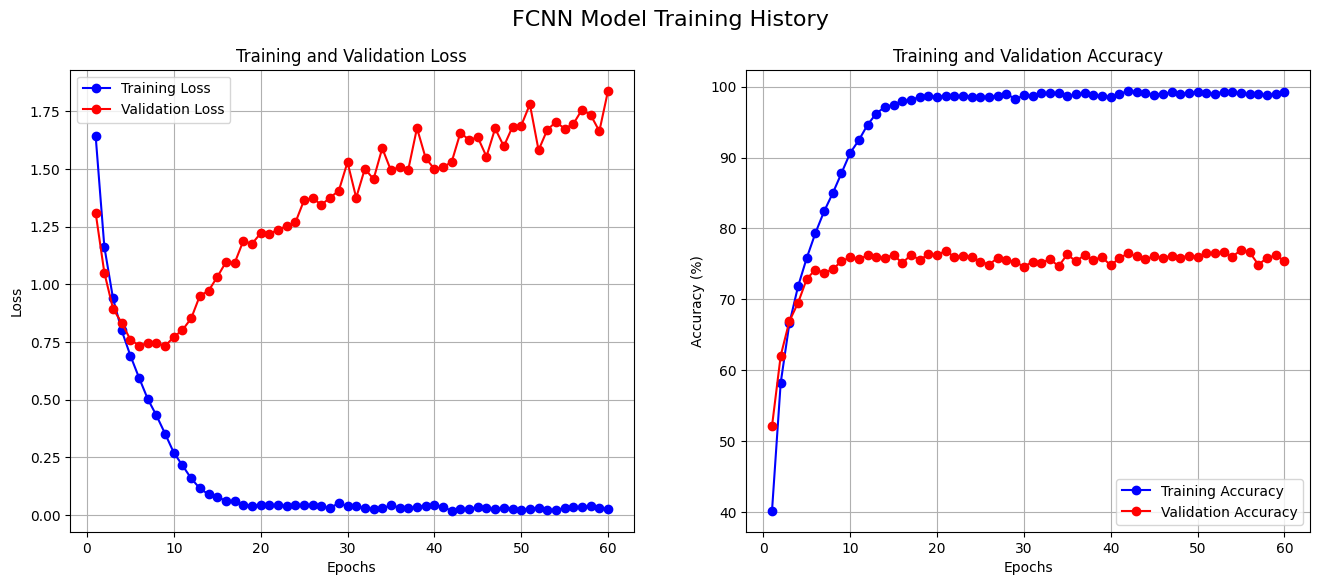

In [25]:
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- Plot Loss ---
ax1.plot(epochs_range, history['train_loss'], 'b-o', label='Training Loss')
ax1.plot(epochs_range, history['val_loss'], 'r-o', label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# --- Plot Accuracy ---
ax2.plot(epochs_range, history['train_acc'], 'b-o', label='Training Accuracy')
ax2.plot(epochs_range, history['val_acc'], 'r-o', label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

fig.suptitle('FCNN Model Training History', fontsize=16)
plt.show()

## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `80%`

In [26]:
print("Evaluating model on the test dataset...")

test_loss, test_accuracy = eval_epoch(model, criterion, testloader)

print("-" * 30)
print(f"Final Test Loss: {test_loss:.4f}")
print(f"Final Test Accuracy: {test_accuracy:.2f}%")
print("-" * 30)

Evaluating model on the test dataset...
------------------------------
Final Test Loss: 1.8683
Final Test Accuracy: 76.36%
------------------------------


## Comparison

FCNN accuracy is: 56% and CNN accuracy is: 77%
CNN accuracy is wat better and the reason behind it is FCNN flattens the data in to 1D vectors and completely ignores some relations like the edges and pixels near each other and ... any information that is given to us by the second dimension is ignored so FCNN is not a good choice for images because usually pixels are really related to all of their adjacent pixels and we are ignoring that information but in CNN we are using the data as is, we are keepin the 2D structure to find out more relations and not lose any information. 

## Visualize incorrectly predicted samples from testset

Visualize *24* random images from testset that are incorrectly predicted by the model. Note that if you used normalization in the transform function for loading the data, you will need to unnormalize the images before displaying them.

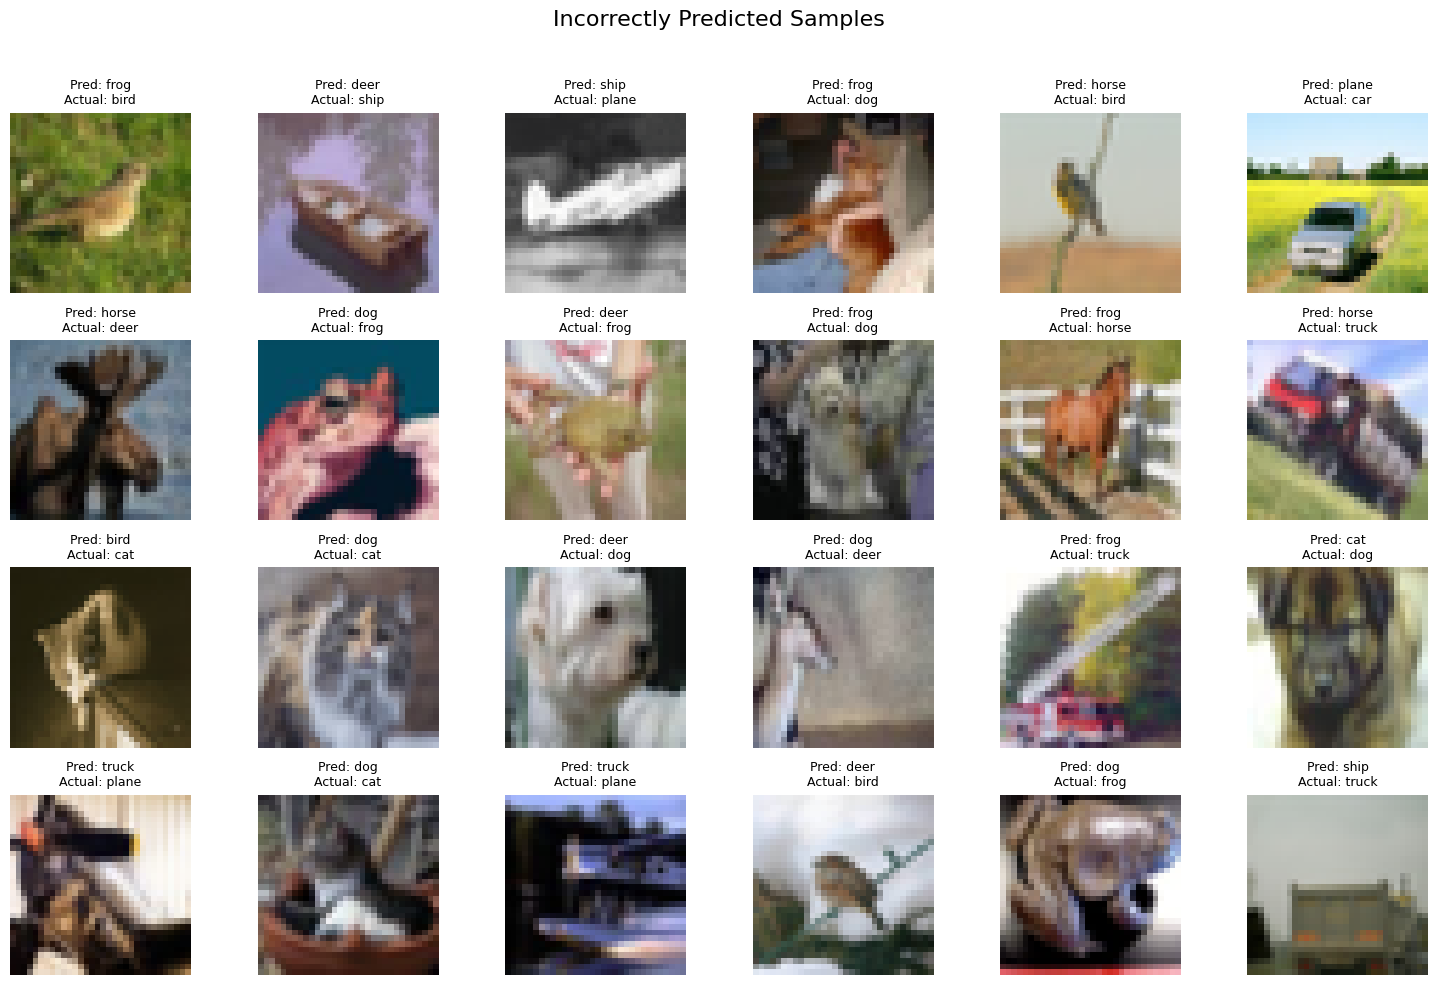

In [27]:
incorrect_samples = []
model.eval()

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        incorrect_indices = (predicted != labels).nonzero(as_tuple=True)[0]
        
        for idx in incorrect_indices:
            incorrect_samples.append({
                "image": images[idx].cpu(),
                "predicted": predicted[idx].cpu().item(),
                "actual": labels[idx].cpu().item()
            })

num_to_display = 24
if len(incorrect_samples) > num_to_display:
    display_samples = random.sample(incorrect_samples, num_to_display)
else:
    display_samples = incorrect_samples

fig, axs = plt.subplots(4, 6, figsize=(15, 10))
fig.suptitle('Incorrectly Predicted Samples', fontsize=16)

for i, sample in enumerate(display_samples):
    ax = axs[i // 6, i % 6]
    
    img = norminv(sample["image"])
    img = img.permute(1, 2, 0)
    ax.imshow(img)
    ax.axis('off')
    
    pred_class = classes[sample["predicted"]]
    actual_class = classes[sample["actual"]]
    ax.set_title(f"Pred: {pred_class}\nActual: {actual_class}", fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Exploring the feature space

### Calculate the feature space for all training samples

You have trained and evaluated your model. Now, for each sample in the trainset, calculate it's "feature space" discussed in the model section. The result of this section should be a tensor of size `(45000, N)` saved in a variable (for later usage)

- **Hint:** Pay attension to the `shuffle` attribute of your train dataloader (If needed)

In [28]:
train_features_loader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=False)

all_features = []
all_labels = []
model.eval()
print("Calculating feature space for all training samples...")
with torch.no_grad():
    for images, labels in train_features_loader:
        images = images.to(device)        
        _, features_batch = model(images, return_features=True)
        
        # Move features to CPU ????
        all_features.append(features_batch.cpu())
        all_labels.append(labels.cpu())

feature_space_tensor = torch.cat(all_features, dim=0)
train_labels_tensor = torch.cat(all_labels, dim=0)

print("Calculation complete.")
print(f"Shape of the feature space tensor: {feature_space_tensor.shape}")
print(f"Shape of the labels tensor: {train_labels_tensor.shape}")

Calculating feature space for all training samples...
Calculation complete.
Shape of the feature space tensor: torch.Size([45000, 8100])
Shape of the labels tensor: torch.Size([45000])


### K Nearest Neighbor in feature space

We already have calculated the feature spaces for trainset ($S$) in the previous section. Now we follow these steps to explore the featre space:

1. Get 5 random samples from testset which are correctly predicted by the model.
2. for each sample, calculate it's "feature space" ($X$)
3. for each sample, calculate it's *5* nearest neighbors in "feature space" in the trainset (by comparing $X$ to each row in $S$) and visualize them

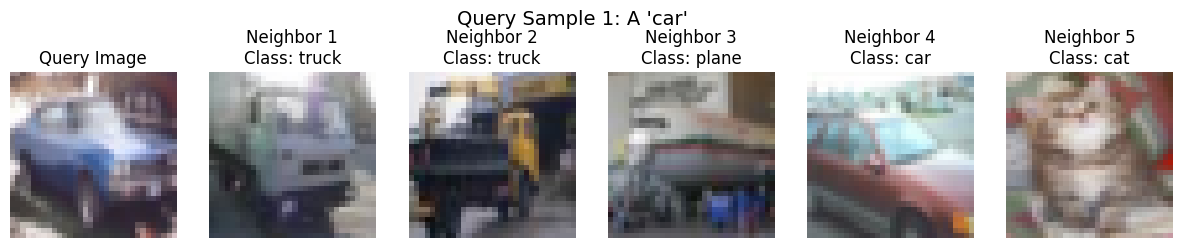

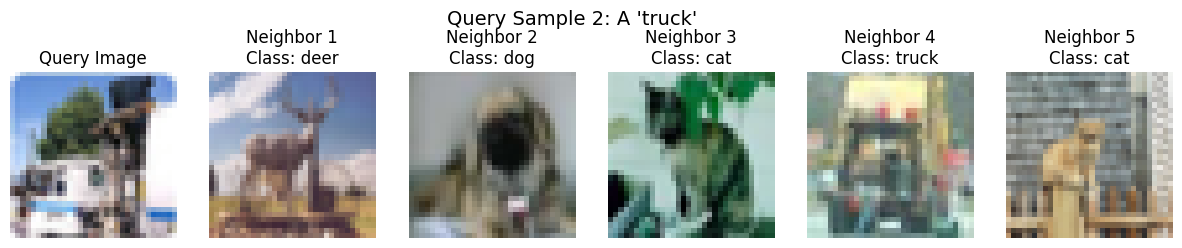

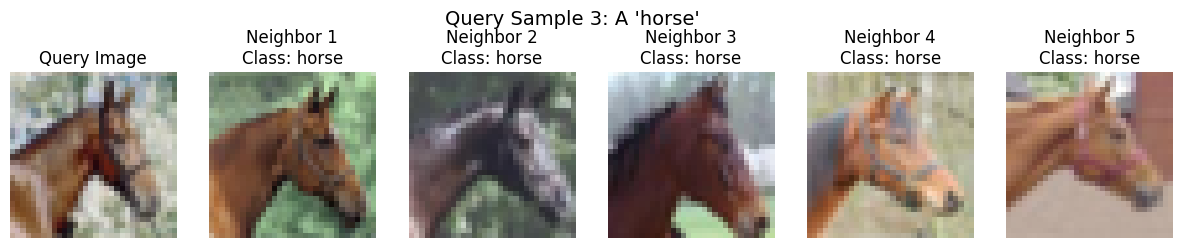

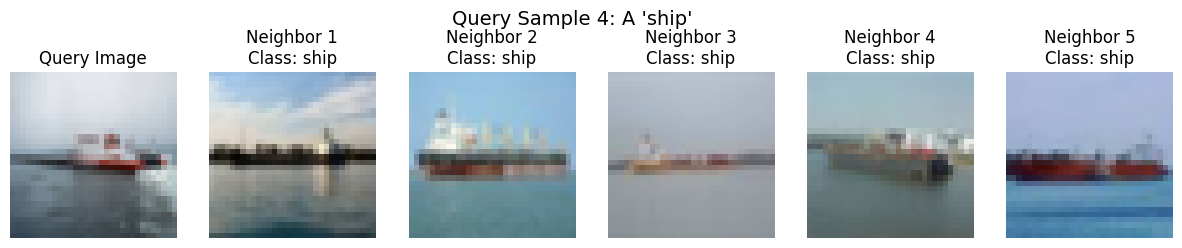

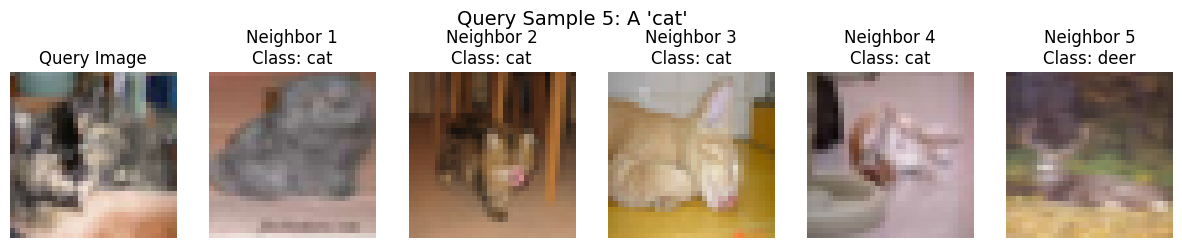

In [29]:
feature_space = feature_space_tensor
correct_samples = []
model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs, features = model(images, return_features=True)
        _, predicted = torch.max(outputs.data, 1)
        
        correct_indices = (predicted == labels).nonzero(as_tuple=True)[0]
        for idx in correct_indices:
            correct_samples.append({
                "image": images[idx],
                "feature_vector": features[idx].cpu(),
                "label": labels[idx].item()
            })

query_samples = random.sample(correct_samples, 5)


for i, sample in enumerate(query_samples):
    test_feature_vector = sample["feature_vector"]
    distances = torch.norm(feature_space - test_feature_vector, dim=1)    
    _, neighbor_indices = torch.topk(distances, k=5, largest=False)
    
    fig, axs = plt.subplots(1, 6, figsize=(15, 3))
    fig.suptitle(f"Query Sample {i+1}: A '{classes[sample['label']]}'", fontsize=14)
    
    query_img_unnorm = norminv(sample["image"])
    axs[0].imshow(query_img_unnorm.cpu().permute(1, 2, 0))
    axs[0].set_title("Query Image")
    axs[0].axis('off')
    
    for j, neighbor_idx in enumerate(neighbor_indices):
        neighbor_img, neighbor_label = trainset[neighbor_idx.item()]
        
        neighbor_img_unnorm = norminv(neighbor_img)
        axs[j+1].imshow(neighbor_img_unnorm.permute(1, 2, 0))
        axs[j+1].set_title(f"Neighbor {j+1}\nClass: {classes[neighbor_label]}")
        axs[j+1].axis('off')
        
    plt.show()

## what have the model learend

Its not purely based on appearance, model has learned both the visual features and undrestanded the concept of each animal.
for example we have the first query in which we have found deers and they have diffrent poses and colors meaning the model is not purely base

### TSNE

Let's follow these steps to explore feature space even more:

1. Sample $M$ ($2000$ would be enought) random samples from the trainset feature space (calculated in the above sections)
2. Now we have a vector of size `(M, N)` where $N$ is the dimension of the feature space
3. Using TSNE reduce $N$ to $2$ (Now we have a vector of size `(M, 2)`)
4. Visualize the points in a 2D plane (Set color of each point based on it's class)


In [30]:
from sklearn.manifold import TSNE

indices = np.random.randint(0, len(feature_space), 2000)
feature_space = feature_space[indices]
tsne = TSNE(n_components=2, random_state=42)
reduced_space = tsne.fit_transform(feature_space.reshape(feature_space.shape[0], -1).detach().cpu().numpy())# Assumes 'feature_space_tensor' and 'train_labels_tensor' are available

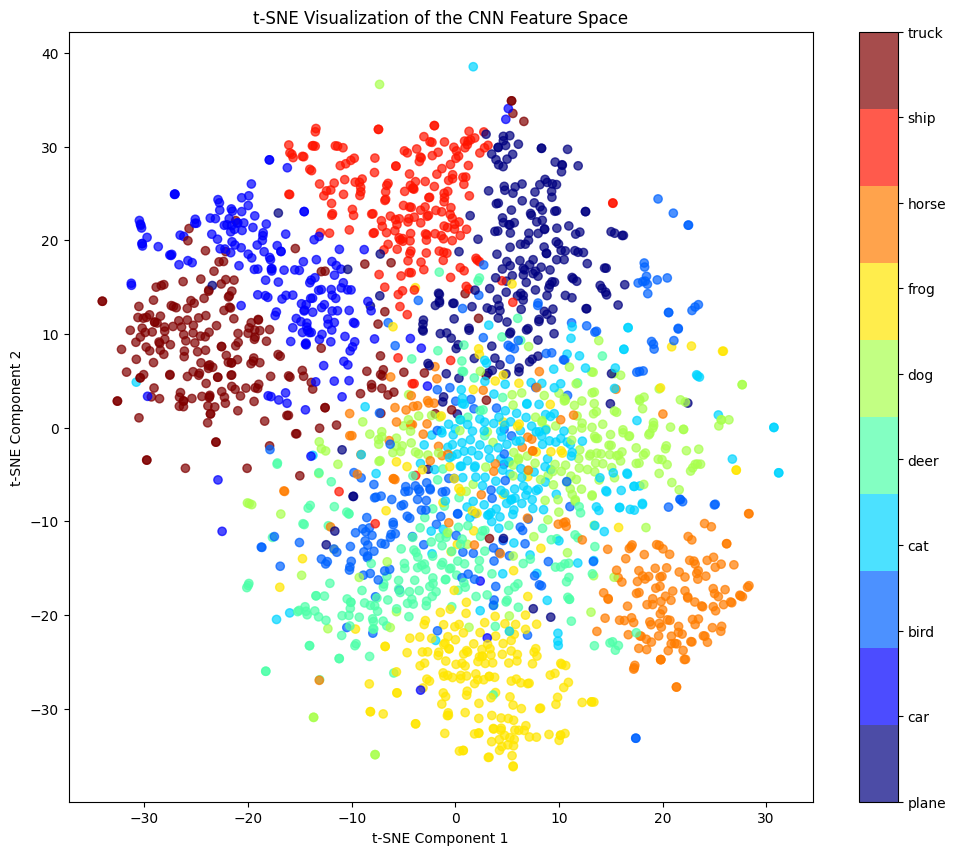

In [31]:
sampled_labels = train_labels_tensor[indices].detach().cpu().numpy()
plt.figure(figsize=(12, 10))
scatter = plt.scatter(reduced_space[:, 0], reduced_space[:, 1], c=sampled_labels, cmap=plt.get_cmap("jet", 10), alpha=0.7)
plt.title('t-SNE Visualization of the CNN Feature Space')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

cbar = plt.colorbar(scatter, ticks=range(10))
cbar.set_ticklabels(classes)

plt.show()

This image shows that the model has succesfuly made sections for some of the classes for example truck and ship.
and for the ones that are not clustered correctly and are messy the reason is that the featers or not good, or at least not distinct enough to give us seperate clusters that we are more deterministic on them.


### Feature Map


In this part, we are going to visualize the output of one of the convolutional layers to see what features they focus on.

First, let's select a random image from dataset.

In [32]:
image = trainset[3][0]

Now, we are going to *clip* our model at different points to get different intermediate representation.
* Clip your model at least at one point and plot the filters output. You can use the output of first Resnet block.

In order to clip the model, you can use `model.children()` method. For example, to get output only after the first 2 layers, you can do:

```
clipped = nn.Sequential(
    *list(model.children()[:2])
)
intermediate_output = clipped(input)
```



In [33]:
input_tensor = image.unsqueeze(0).to(device)
clipped_model = nn.Sequential(*list(model.conv_extractor.children())[:2])
model.eval()
with torch.no_grad():
    intermediate_output = clipped_model(input_tensor)

In [34]:
intermediate_output.shape

torch.Size([1, 64, 32, 32])

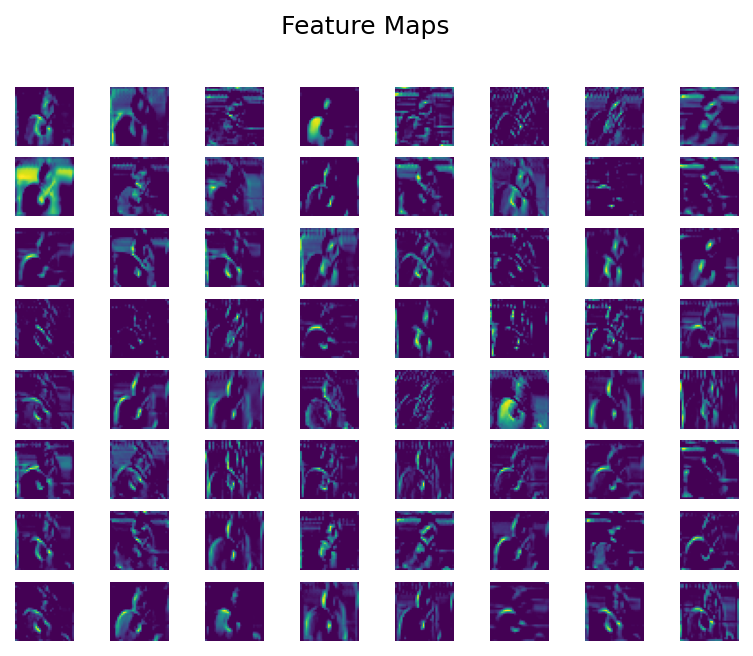

In [35]:
import matplotlib.pyplot as plt

def plot_intermediate_output(result, title=None):
    """ 
    Plots the intermediate output of shape
    N_FILTERS x H x W
    """
    plt.rcParams['figure.dpi'] = 150
    n_filters = result.shape[1]
    N = int(math.sqrt(n_filters))
    M = (n_filters + N - 1) // N
    assert N * M >= n_filters

    fig, axs = plt.subplots(N, M)
    fig.suptitle(title)

    for i in range(N):
        for j in range(M):
            if i*N + j < n_filters:
                axs[i][j].imshow(result[0, i*N + j].cpu().detach())
                axs[i][j].axis('off')

plot_intermediate_output(intermediate_output, title='Feature Maps')


**Note:** You are expected to analyze all results presented in this notebook and thoughtfully consider the underlying reasons behind them. Be prepared to discuss your insights during the **in-person review session**.
A written report is not required.
